In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-27 23:16:54.646596: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-27 23:16:54.749103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-27 23:16:54.749139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-27 23:16:54.762195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-27 23:16:54.792401: I tensorflow/core/platform/cpu_feature_guar

# fixed bias, noiseless, kmax=0.4

In [2]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_b1000_p0_n1'
tag_noise = None
tag_Anoise = None

n_train = 10000
#statistics_arr = [['pk']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [3]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [4]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = None
tag_Anoise_fixed = None
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[0.3175 0.834  0.6711 0.049  0.9624]


In [5]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
if tag_noise_fixed is None:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + '_mean' for tag_stats in tag_stats_arr]
else:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
param_names_contour = cosmo_param_names_vary
#param_names_contour = ['omega_cold', 'sigma8_cold']
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_b1000_p0_n1_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_b1000_p0_n1_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy


FileNotFoundError: [Errno 2] No such file or directory: '../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_b1000_p0_n1_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy'

### inference results: coverage set

In [6]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
#tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tags_biasparams_test = ['_b1000_p0_n1']*len(tags_inf)
tags_noise_test = None
tags_Anoise_test = None
tags_mask_test = ['', '', '']
tag_datagen_test = ''               

tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_b1000_p0_n1
_muchisimocks_bispec_test_p5_n1000_b1000_p0_n1
_muchisimocks_pk_bispec_test_p5_n1000_b1000_p0_n1


In [7]:
param_names_show = cosmo_param_names_vary
#param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_b1000_p0_n1_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_b1000_p0_n1_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_b1000_p0_n1_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_b1000_p0_n1_pred.npy


FileNotFoundError: [Errno 2] No such file or directory: '../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_b1000_p0_n1_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_b1000_p0_n1_pred.npy'

In [73]:
theta_pred_arr.shape, theta_true_arr.shape, vars_pred_arr.shape, covs_pred_arr.shape

((1, 1000, 5), (1, 1000, 5), (1, 1000, 5), (1, 1000, 5, 5))

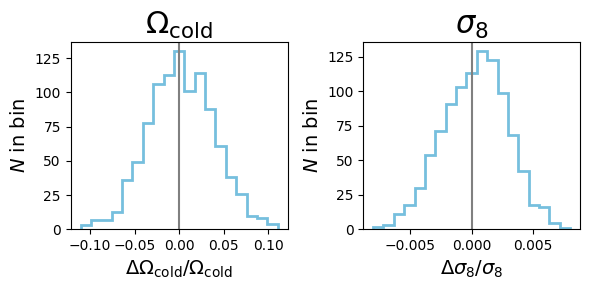

In [76]:
param_names_key = ['omega_cold', 'sigma8_cold']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
# print(fracdiffs_arr.shape)
# for param_name in param_names_key:
#     std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
#     std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
#     improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
#     print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

# orig: free bias, noiseless, kmax=0.4

In [2]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = None
tag_Anoise = None

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [3]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [4]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = None
tag_Anoise_fixed = None
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test None
[]
{}
9
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.    ]
9


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy


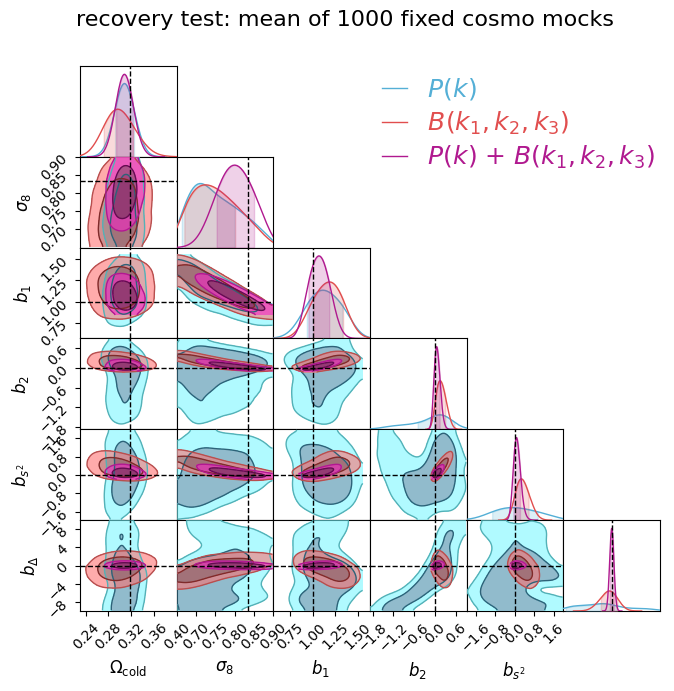

In [5]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
if tag_noise_fixed is None:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + '_mean' for tag_stats in tag_stats_arr]
else:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### inference results: coverage set

In [6]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tags_noise_test = None
tags_Anoise_test = None
tags_mask_test = ['', '', '']
tag_datagen_test = ''               

tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000


In [7]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy
1000
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_pred.npy
1000
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_pred.npy
1000


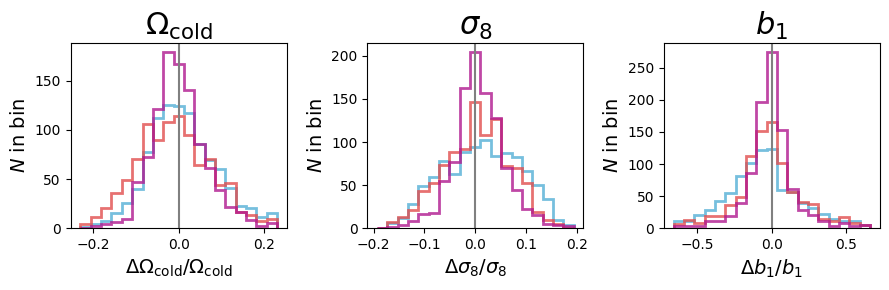

(3, 1000, 9)
omega_cold: 1.298 (0.089 / 0.068)
sigma8_cold: 1.487 (0.074 / 0.050)
b1: 3.617 (7.060 / 1.952)


In [8]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
print(fracdiffs_arr.shape)
for param_name in param_names_key:
    std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
    std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
    improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
    print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

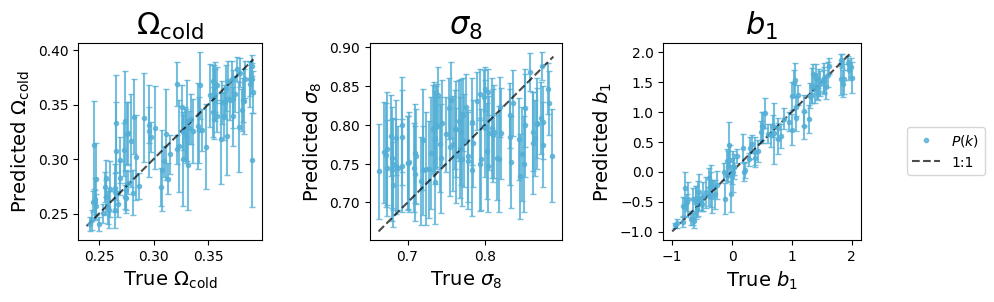

In [ ]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
idx_stat = 0 # p
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

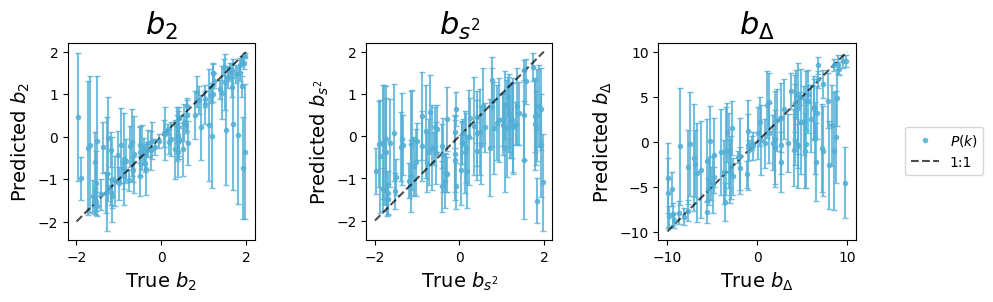

In [10]:
param_names_key = ['b2', 'bs2', 'bl']
idx_stat = 0 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

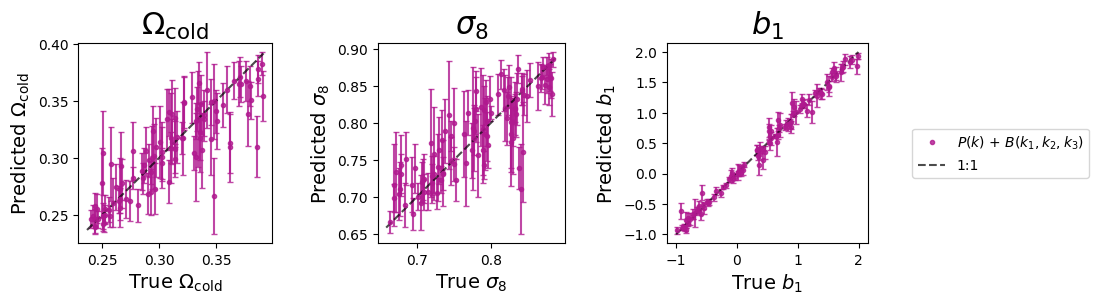

In [11]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

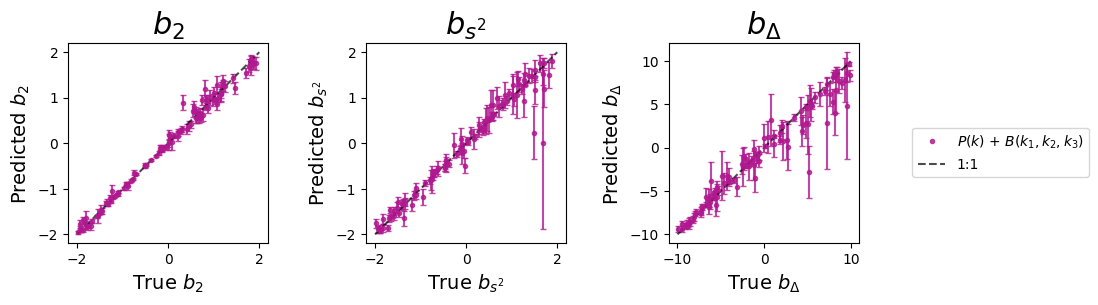

In [13]:
param_names_key = ['b2', 'bs2', 'bl']
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

# free bias, R+S noise, kmax=0.4

In [44]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [45]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [18]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


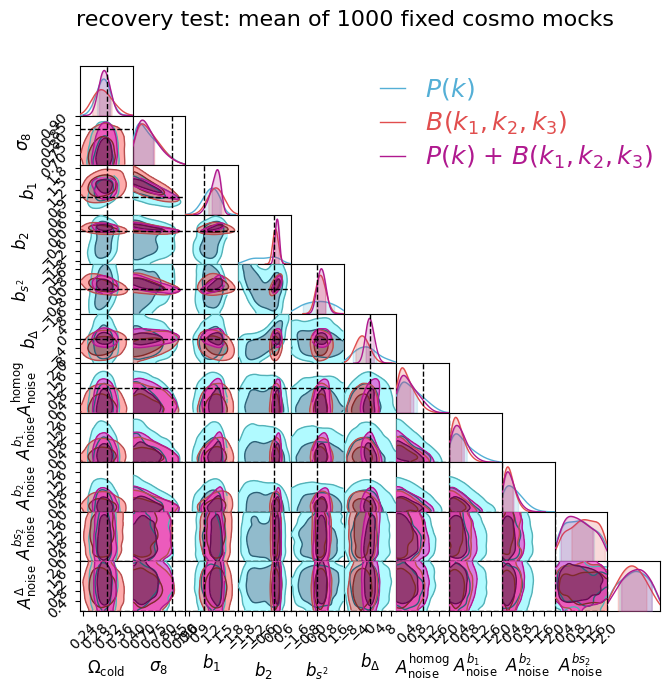

In [19]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
if tag_noise_fixed is None:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + '_mean' for tag_stats in tag_stats_arr]
else:
    tags_test = ['_'+data_mode + tag_stats + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for tag_stats in tag_stats_arr]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### inference results: coverage set

In [24]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tag_biasparams_test = '_biaszen_p4_n1000'
tag_noise_test = '_noise_unit_test_p5_n1000'
tag_Anoise_test = '_Anmult_p5_n1000'
tags_mask_test = ['', '', '']
tag_datagen_test = ''               

if tag_noise_test is None:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tag_biasparams_test + tag_datagen_test for i in range(len(tag_stats_arr))]
else:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tag_biasparams_test + tag_noise_test + tag_Anoise_test + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000


In [25]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_pred.npy


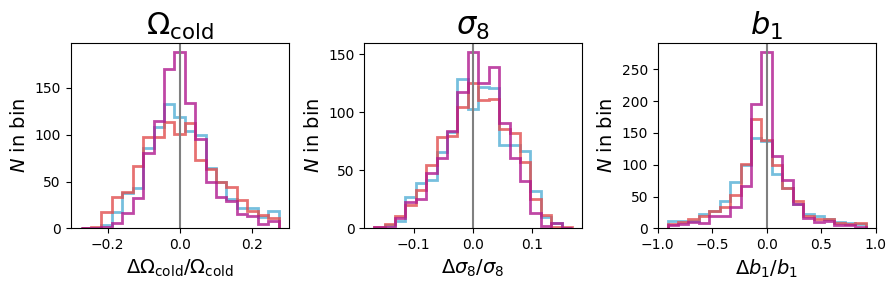

(3, 1000, 9)
omega_cold: 1.302 (0.107 / 0.082)
sigma8_cold: 1.115 (0.056 / 0.050)
b1: 1.144 (5.949 / 5.201)


In [26]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
print(fracdiffs_arr.shape)
for param_name in param_names_key:
    std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
    std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
    improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
    print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

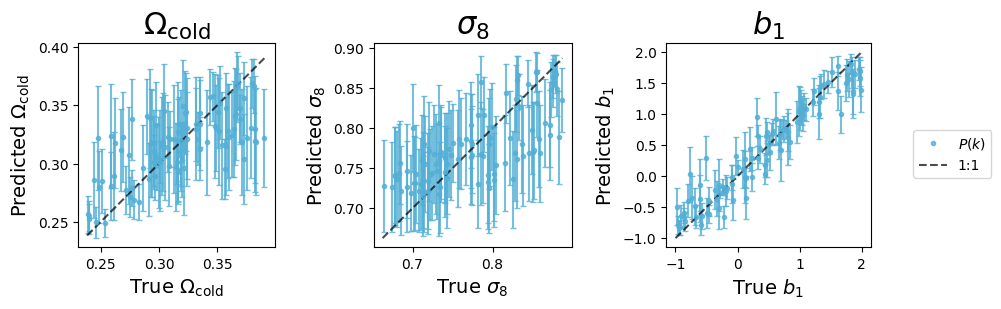

In [27]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
idx_stat = 0 # p
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

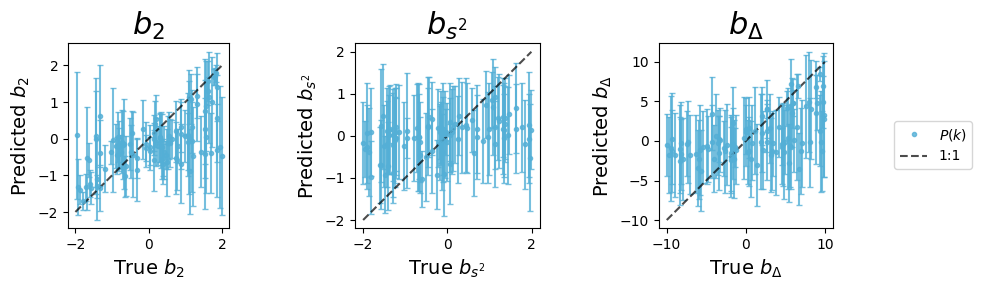

In [28]:
param_names_key = ['b2', 'bs2', 'bl']
idx_stat = 0 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

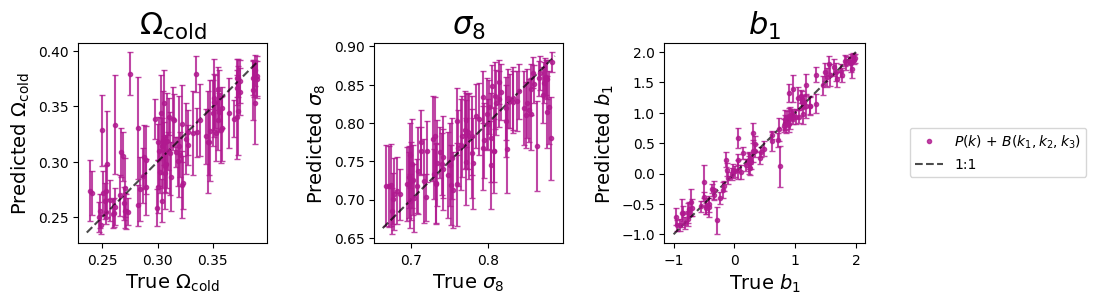

In [29]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

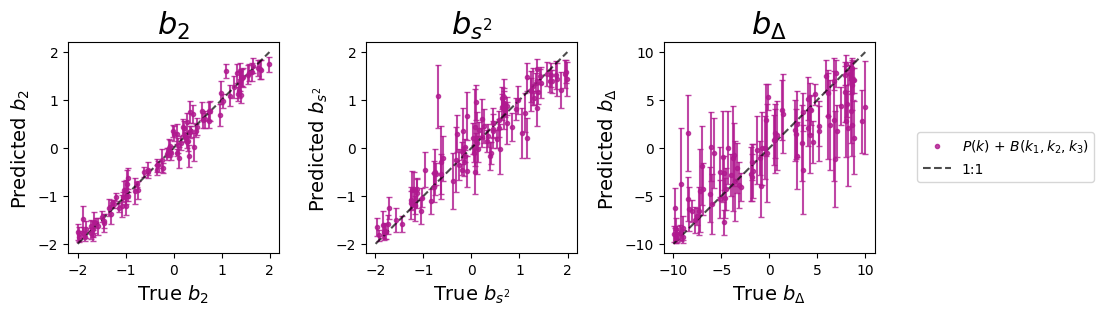

In [30]:
param_names_key = ['b2', 'bs2', 'bl']
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

### Inference results: shame

In [46]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy


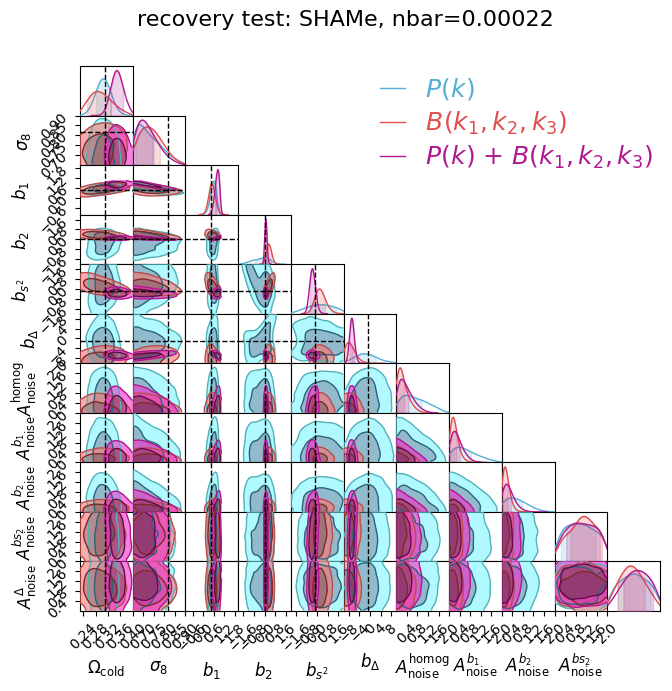

In [47]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_nbar0.00022_pred.npy


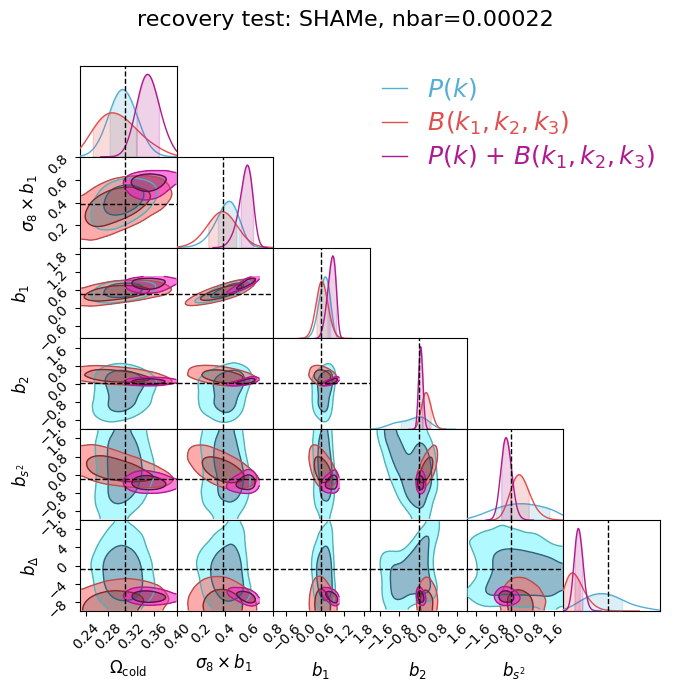

In [51]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf_reparam(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents,
                         reparameterize=True, params_show_reparameterize=['sigma8xb1', 'b1'])

# free bias, R+S noise, kmax=0.25

In [52]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tags_mask = ['', '_kmaxbispec0.25', '_kmaxbispec0.25']
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tags_mask[i]}{tag_params}{tag_biasparams}_ntrain{n_train}' for i, tag_stats in enumerate(tag_stats_arr)]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tags_mask[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i, tag_stats in enumerate(tag_stats_arr)]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [53]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [54]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
tag_mask_test_fixed = ['', '_kmaxbispec0.25', '_kmaxbispec0.25']
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.25_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained
Parameter An_bl in chain $B(k_1,k_2,k_3)$ is not constrained


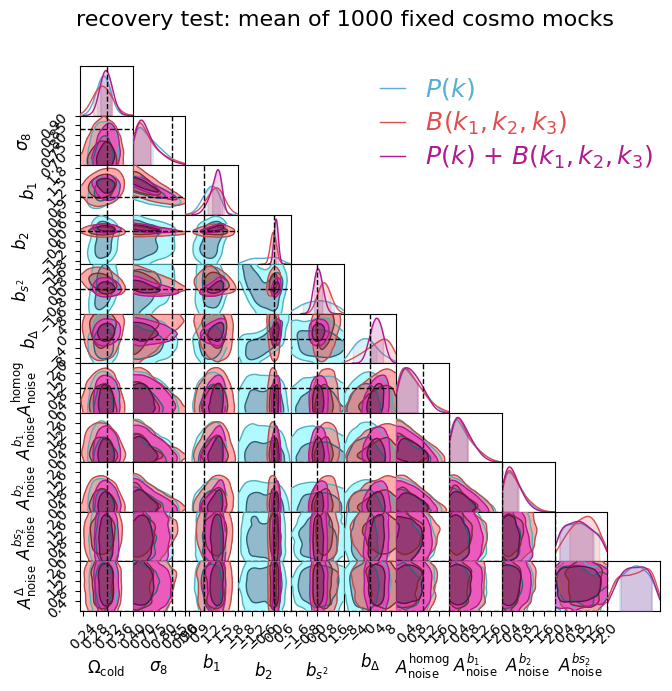

In [55]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
if tag_noise_fixed is None:
    tags_test = ['_'+data_mode + tag_stats + tag_mask_test_fixed[i] + tag_params_test_fixed + tag_biasparams_test_fixed + '_mean' for i, tag_stats in enumerate(tag_stats_arr)]
else:
    tags_test = ['_'+data_mode + tag_stats + tag_mask_test_fixed[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i, tag_stats in enumerate(tag_stats_arr)]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### inference results: coverage set

In [56]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tag_biasparams_test = '_biaszen_p4_n1000'
tag_noise_test = '_noise_unit_test_p5_n1000'
tag_Anoise_test = '_Anmult_p5_n1000'
tags_mask_test = ['', '_kmaxbispec0.25', '_kmaxbispec0.25']
tag_datagen_test = ''               

if tag_noise_test is None:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tag_biasparams_test + tag_datagen_test for i in range(len(tag_stats_arr))]
else:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tag_biasparams_test + tag_noise_test + tag_Anoise_test + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
_muchisimocks_bispec_kmaxbispec0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000
_muchisimocks_pk_bispec_kmaxbispec0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000


In [57]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_pred.npy
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.25_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p5_n1000_pred.npy


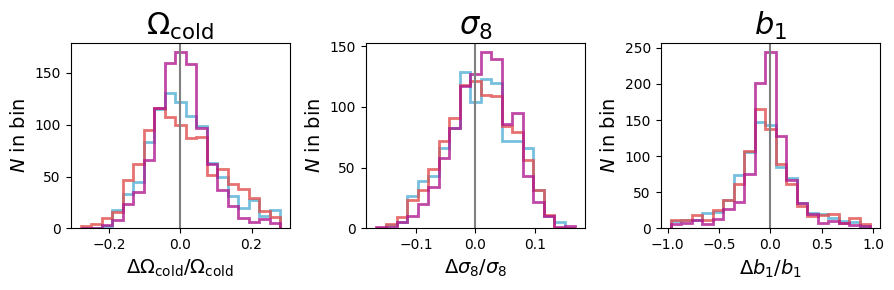

(3, 1000, 9)
omega_cold: 1.260 (0.107 / 0.085)
sigma8_cold: 1.127 (0.056 / 0.050)
b1: 1.144 (5.949 / 5.200)


In [58]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
print(fracdiffs_arr.shape)
for param_name in param_names_key:
    std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
    std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
    improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
    print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

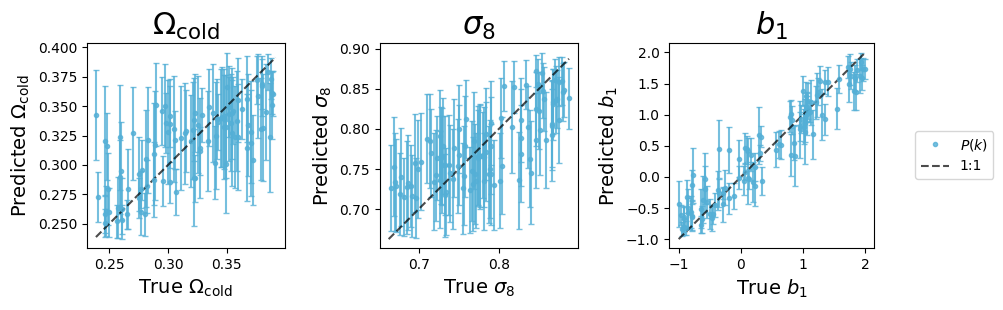

In [59]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
idx_stat = 0 # p
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

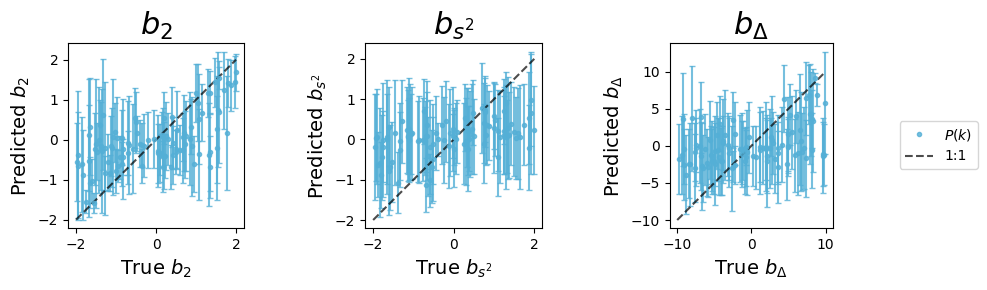

In [60]:
param_names_key = ['b2', 'bs2', 'bl']
idx_stat = 0 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

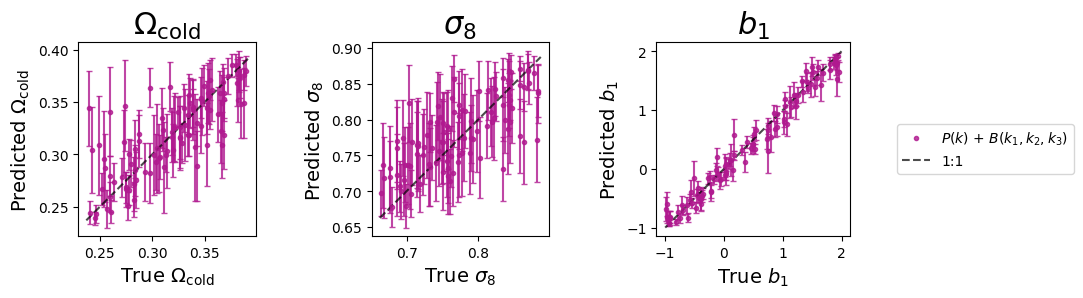

In [61]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

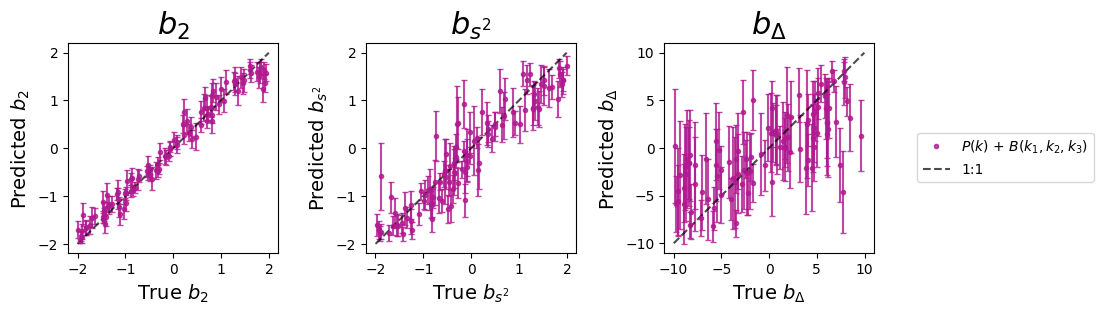

In [62]:
param_names_key = ['b2', 'bs2', 'bl']
idx_stat = 2 # p+b
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

### Inference results: shame

In [63]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
tags_mask_test = ['', '_kmaxbispec0.25', '_kmaxbispec0.25']
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.25_nbar0.00022_pred.npy


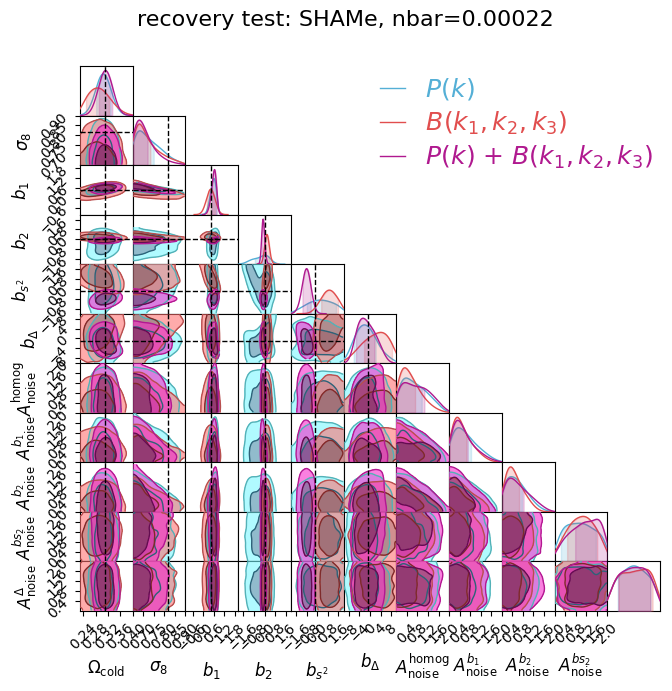

In [64]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tags_mask_test[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.25_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.25_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.25_nbar0.00022_pred.npy


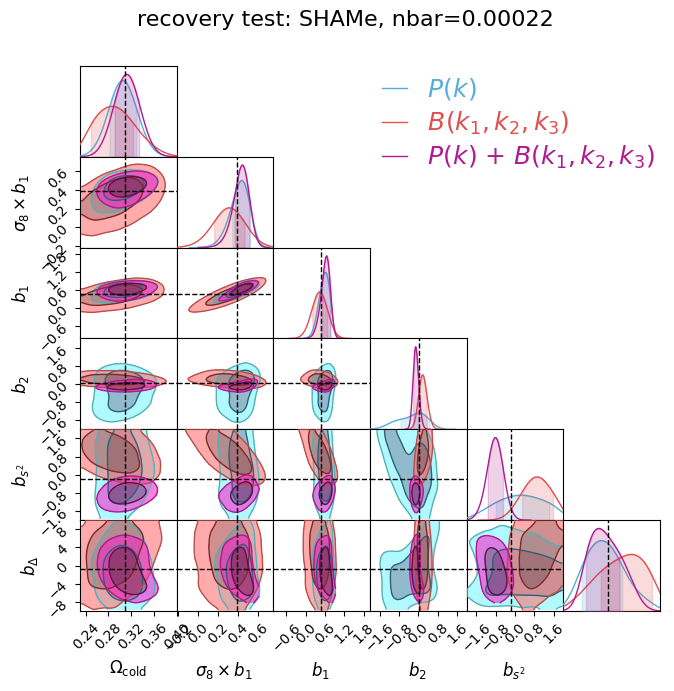

In [66]:
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf_reparam(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents,
                         reparameterize=True, params_show_reparameterize=['sigma8xb1', 'b1'])